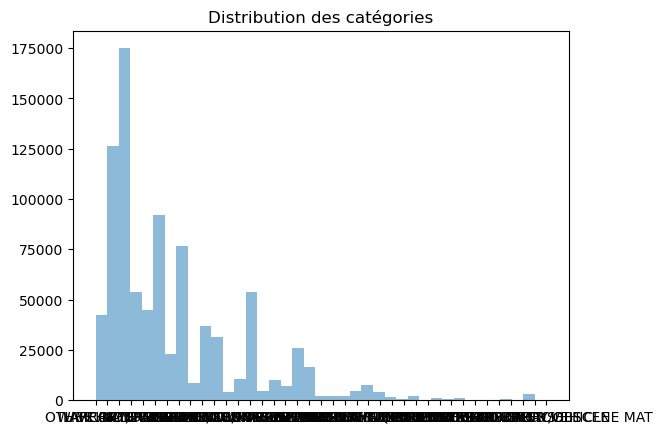

Avant SMOTE : Counter({16: 174900, 21: 126182, 20: 92304, 1: 76876, 7: 53971, 36: 53781, 35: 44725, 37: 42214, 4: 36755, 32: 31414, 19: 25989, 25: 23000, 13: 16679, 12: 10609, 27: 9985, 38: 8555, 23: 7484, 34: 7326, 30: 4540, 28: 4388, 5: 4320, 8: 4280, 24: 3138, 15: 2341, 6: 2268, 26: 1946, 17: 1903, 0: 1513, 18: 1225, 9: 1166, 31: 508, 11: 491, 2: 406, 3: 289, 10: 256, 29: 148, 14: 146, 22: 22, 33: 6})
Après SMOTE : Counter({37: 174900, 21: 174900, 16: 174900, 36: 174900, 35: 174900, 20: 174900, 25: 174900, 1: 174900, 38: 174900, 4: 174900, 32: 174900, 8: 174900, 12: 174900, 7: 174900, 30: 174900, 27: 174900, 34: 174900, 19: 174900, 13: 174900, 15: 174900, 26: 174900, 6: 174900, 28: 174900, 23: 174900, 5: 174900, 0: 174900, 11: 174900, 17: 174900, 3: 174900, 9: 174900, 31: 174900, 18: 174900, 29: 174900, 10: 174900, 14: 174900, 2: 174900, 33: 174900, 24: 174900, 22: 174900})


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, DMatrix, train as xgb_train
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import optuna
from collections import Counter

# Chargement des données
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Transformation des dates
train_data['Dates'] = pd.to_datetime(train_data['Dates'])
test_data['Dates'] = pd.to_datetime(test_data['Dates'])

# Extraction des caractéristiques temporelles
for df in [train_data, test_data]:
    df['Hour'] = df['Dates'].dt.hour
    df['Day'] = df['Dates'].dt.day
    df['Month'] = df['Dates'].dt.month
    df['Year'] = df['Dates'].dt.year
    df['DayOfWeek_num'] = df['Dates'].dt.dayofweek

# Encodage OneHot pour 'DayOfWeek' et 'PdDistrict'
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
train_ohe = encoder.fit_transform(train_data[['DayOfWeek', 'PdDistrict']])
test_ohe = encoder.transform(test_data[['DayOfWeek', 'PdDistrict']])

# Ajout des nouvelles colonnes encodées
dow_dist_cols = encoder.get_feature_names_out()
train_data = pd.concat([train_data.drop(columns=['DayOfWeek', 'PdDistrict']),
                        pd.DataFrame(columns=dow_dist_cols, data=train_ohe)], axis=1)
test_data = pd.concat([test_data.drop(columns=['DayOfWeek', 'PdDistrict']),
                       pd.DataFrame(columns=dow_dist_cols, data=test_ohe)], axis=1)

# Standardisation des colonnes X et Y
scaler = StandardScaler()
train_data[['X', 'Y']] = scaler.fit_transform(train_data[['X', 'Y']])
test_data[['X', 'Y']] = scaler.transform(test_data[['X', 'Y']])

# Encodage de la variable cible
y_train_cat = train_data['Category']
label_encoder = LabelEncoder()
y_train_cat_encoded = label_encoder.fit_transform(y_train_cat)

# Filtrage des colonnes utiles
cols_to_keep = ['Hour', 'Day', 'Month', 'Year', 'DayOfWeek_num', 'X', 'Y'] + list(dow_dist_cols)
train_data = train_data[cols_to_keep]
test_data = test_data[cols_to_keep]

# Visualisation de la distribution des catégories
plt.hist(y_train_cat, bins=len(np.unique(y_train_cat)), alpha=0.5)
plt.title("Distribution des catégories")
plt.show()

# Application de SMOTE (équilibrage des classes)
print("Avant SMOTE :", Counter(y_train_cat_encoded))
smote = SMOTE(random_state=42, sampling_strategy="auto")
X_resampled, y_resampled = smote.fit_resample(train_data, y_train_cat_encoded)
print("Après SMOTE :", Counter(y_resampled))

# Division des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.2, random_state=42, stratify=y_resampled)

# Conversion explicite des données en DMatrix pour le GPU
dtrain = DMatrix(X_train, label=y_train)
dtest = DMatrix(X_test, label=y_test)

In [2]:
print(f"Dimensions y_test : {y_test.shape}")
print(f"Dimensions y_train : {y_train.shape}")

Dimensions y_test : (1364220,)
Dimensions y_train : (5456880,)


In [3]:
# Création de la barre de progression globale
n_trials = 10  # Ajustez le nombre d'essais pour Optuna
pbar = tqdm(total=n_trials, desc="Optuna Trials", position=0)

# Fonction d'objectif pour Optuna
def objective(trial):
    params = {
        "objective": "multi:softprob",  # Pour la classification multi-classes
        "num_class": 39,  # Nombre de classes
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
        "tree_method": "hist",  # Utilisation optimisée pour le GPU
        "device": "cuda"  # Exécution sur GPU
    }

    # Entraînement du modèle
    bst = xgb_train(params, dtrain, num_boost_round=100)

    # Évaluation
    y_pred_prob = bst.predict(dtest)
    loss = log_loss(y_test, y_pred_prob)

    # Mise à jour de la barre de progression
    pbar.update(1)
    return loss

# Création de l’étude Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=n_trials)

# Fermeture de la barre de progression
pbar.close()

# Affichage des meilleurs paramètres
print("Best Parameters:", study.best_params)
print("Best Log Loss:", study.best_value)


Optuna Trials: 100%|██████████| 10/10 [24:36<00:00, 147.65s/it]

Best Parameters: {'max_depth': 10, 'learning_rate': 0.020440499071406045, 'subsample': 0.843761910954788, 'colsample_bytree': 0.5506192965400769, 'gamma': 1.5223752658723395, 'reg_alpha': 0.5718309764553302, 'reg_lambda': 1.1986373770338077}
Best Log Loss: 2.541873171022386


In [4]:
# Ajout après l'optimisation Optuna
final_params = study.best_params
final_params.update({
    "objective": "multi:softprob",  # Pour multi-classes
    "num_class": 39,  # Nombre total de classes
    "tree_method": "hist",  # GPU
    "device": "cuda"  # GPU
})

# Entraînement final avec les meilleurs paramètres
final_model = xgb_train(final_params, dtrain, num_boost_round=100)

In [12]:
print(f"Dimensions y_test : {y_test.shape}")
#print(f"Dimensions y_pred_prob : {y_pred_prob.shape}")
print(f"Nombre de classes dans y_test : {len(np.unique(y_test))}")
print(f"Dimensions y_train : {y_train.shape}")


Dimensions y_test : (1364220,)
Nombre de classes dans y_test : 39
Dimensions y_train : (5456880,)


In [14]:
# Conversion explicite du test Kaggle en DMatrix
dtest_kaggle = DMatrix(test_data)

# Génération des prédictions
y_pred_prob_kaggle = final_model.predict(dtest_kaggle)

# Vérification des dimensions des prédictions
print(f"Taille des prédictions pour Kaggle : {y_pred_prob_kaggle.shape}")

Taille des prédictions pour Kaggle : (884262, 39)


In [15]:
print(test_data.columns)  # Vérifie si 'Id' est une colonne de test_data


Index(['Hour', 'Day', 'Month', 'Year', 'DayOfWeek_num', 'X', 'Y',
       'DayOfWeek_Monday', 'DayOfWeek_Saturday', 'DayOfWeek_Sunday',
       'DayOfWeek_Thursday', 'DayOfWeek_Tuesday', 'DayOfWeek_Wednesday',
       'PdDistrict_CENTRAL', 'PdDistrict_INGLESIDE', 'PdDistrict_MISSION',
       'PdDistrict_NORTHERN', 'PdDistrict_PARK', 'PdDistrict_RICHMOND',
       'PdDistrict_SOUTHERN', 'PdDistrict_TARAVAL', 'PdDistrict_TENDERLOIN'],
      dtype='object')


In [16]:
# Ajouter une colonne 'Id' basée sur l'index de test_data
test_data['Id'] = test_data.index

# Convertir les prédictions en DataFrame
categories = label_encoder.classes_  # Les noms des catégories
submission = pd.DataFrame(y_pred_prob_kaggle, columns=categories)

# Ajouter la colonne 'Id'
submission['Id'] = test_data['Id']

# Réorganiser les colonnes pour mettre 'Id' en premier
submission = submission[['Id'] + [col for col in submission.columns if col != 'Id']]

# Exporter au format CSV
submission.to_csv('submission.csv', index=False)

# Afficher les premières lignes pour vérification
print(submission.head())

   Id     ARSON   ASSAULT  BAD CHECKS   BRIBERY  BURGLARY  DISORDERLY CONDUCT  \
0   0  0.040712  0.061727    0.008613  0.022275  0.022789            0.012733   
1   1  0.044306  0.069971    0.008880  0.022899  0.022588            0.013550   
2   2  0.016773  0.061111    0.009064  0.012630  0.064164            0.011693   
3   3  0.018431  0.052487    0.008216  0.015072  0.022188            0.012023   
4   4  0.018431  0.052487    0.008216  0.015072  0.022188            0.012023   

   DRIVING UNDER THE INFLUENCE  DRUG/NARCOTIC  DRUNKENNESS  ...  \
0                     0.035078       0.021915     0.018889  ...   
1                     0.031296       0.027156     0.019919  ...   
2                     0.024093       0.017922     0.019570  ...   
3                     0.036379       0.020627     0.013139  ...   
4                     0.036379       0.020627     0.013139  ...   

   SEX OFFENSES NON FORCIBLE  STOLEN PROPERTY   SUICIDE  SUSPICIOUS OCC  \
0                   0.010375       

In [19]:
print(submission.columns)

Index(['Id', 'ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY',
       'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE', 'DRUG/NARCOTIC',
       'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION', 'FAMILY OFFENSES',
       'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING', 'KIDNAPPING',
       'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING', 'MISSING PERSON',
       'NON-CRIMINAL', 'OTHER OFFENSES', 'PORNOGRAPHY/OBSCENE MAT',
       'PROSTITUTION', 'RECOVERED VEHICLE', 'ROBBERY', 'RUNAWAY',
       'SECONDARY CODES', 'SEX OFFENSES FORCIBLE', 'SEX OFFENSES NON FORCIBLE',
       'STOLEN PROPERTY', 'SUICIDE', 'SUSPICIOUS OCC', 'TREA', 'TRESPASS',
       'VANDALISM', 'VEHICLE THEFT', 'WARRANTS', 'WEAPON LAWS'],
      dtype='object')


In [20]:
print(submission.shape)

(884262, 40)
